![Amsterdam Marathon Logo](images/Amsterdam_Marathon_2013_logo.png)

---

# Introduction

This project's goal is to analyze and work with data from an annual marathon in Amsterdam. The goal is to determine which factors influence final finish time and which do not, and whether we can predict a marathon runner's finish time before and during the race.

---

### Imports
We will load all of the libraries that will be needed throughout the project.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
import threading
import requests
import numpy as np
import pandas as pd
import json
import time
import cchardet
import os
import pycountry
from urllib.parse import urlparse
from urllib.parse import parse_qs
import aiohttp
import asyncio
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn

from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, r2_score

---

# Data acquisition
As previously stated, we will be exploring the race results of the Amsterdam marathon over the years. After arriving at the results page, I came to the following conclusions:

- The results from 2007 to 2015 are stored on an older system, whereas the results from 2016 and on are stored on a different host.
- The first host retrieves table results via URL queries and the data appears immediately in the HTML source after being sent from the server side.
- The second host uses a network request to retrieve the result stored in a JSON object. The data isn't immediately loaded onto the page

To be able to scrape from both hosts, they must be approached differently. Because the first host sends the full HTML with each query, it can be scraped with asynchronous requests and BeautifulSoup. As for the second host, I was able to trace back the API call it made by using the browser's developer tools and inspecting the Network requests. This will allow me to directly access the data and only work with that JSON object.

### Goal and strategy
I intend to retrieve all data from the following years of the marathon:

2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2017, 2018, 2019, 2021

I left out the year 2016 because it lacks some information that every other marathon has.

I also left out the year 2020 due to the low number of participants.

#### Initial declarations

In [2]:
names=list()
poss=list()
bibs=list()
cats=list()
rpos=list()
cnt=list()
km5=list()
km10=list()
km15=list()
km20=list()
km21=list()
km25=list()
km30=list()
km35=list()
km40=list()
kmfin=list()
dates=list()

#### Libraries used

I will be sending asynchronous requests to the site using the **aiohttp/asyncio** library, which will significantly reduce the running time compared to running those requests in a linear fashion. Because I want to know the split times for each tournament entry, I'll have to access each participant's personal page, which means one request per person. Even for the smallest tournament with 6530 participants, it will take 6530 requests, one per row, which is very time consuming if not done asynchronously.


*Credits: https://www.twilio.com/blog/asynchronous-http-requests-in-python-with-aiohttp*

#### 2007-2015 Marathons
Credit: https://www.twilio.com/blog/asynchronous-http-requests-in-python-with-aiohttp

In [3]:
def timestamp(t):
    spl = t.split(":")
    if t and len(spl) < 3:
        return '0:'+t
    return t

# Manually gathered data for maximum page
marathons = [
    (2007,66),
    (2008,60),
    (2009,70),
    (2010,79),
    (2011,97),
    (2012,102),
    (2013,114),
    (2014,123),
    (2015,124)
]

# Test running time
start_time = time.time()

async def handle_entry(session, url, year):
    async with session.get(url) as resp:
        r2 = await resp.text()
        sp = BeautifulSoup(r2, "html.parser")
        try:
            tables = sp.find_all("table")
            left = tables[2].find_all("tr")
            right = tables[3].find_all("tr")
            right.pop(0)
        except IndexError:
            print("IndexError at",url)
            
        parsed = urlparse(url)
        dates.append(year)
        bibs.append(parse_qs(parsed.query)['s'][0])
        names.append(left[0].find_all("td")[1].get_text().strip()) # name
        cnt.append(left[2].find_all("td")[1].get_text().strip()) #country
        cats.append(left[4].find_all("td")[1].get_text().strip()) #category
        poss.append(left[5].find_all("td")[1].get_text().strip().split(' ')[0])#rank
        rpos.append(left[6].find_all("td")[1].get_text().strip())#category rank
        
        kmfin.append(timestamp(left[9].find_all("td")[1].get_text().strip()))
        km5.append(timestamp(right[0].find_all("td")[1].get_text().strip().split(' ')[0]))
        km10.append(timestamp(right[1].find_all("td")[1].get_text().strip().split(' ')[0]))
        km15.append(timestamp(right[2].find_all("td")[1].get_text().strip().split(' ')[0]))
        km20.append(timestamp(right[3].find_all("td")[1].get_text().strip().split(' ')[0]))
        km21.append(timestamp(right[4].find_all("td")[1].get_text().strip().split(' ')[0]))
        km25.append(timestamp(right[5].find_all("td")[1].get_text().strip().split(' ')[0]))
        km30.append(timestamp(right[6].find_all("td")[1].get_text().strip().split(' ')[0]))
        km35.append(timestamp(right[7].find_all("td")[1].get_text().strip().split(' ')[0]))
        km40.append(timestamp(right[8].find_all("td")[1].get_text().strip().split(' ')[0]))

async def handle_page(session, url, year):
    async with session.get(url) as resp:
        r2 = await resp.text()
        sp = BeautifulSoup(r2, "html.parser")
        
        main = f'https://evenementen.uitslagen.nl/{year}/amsterdammarathon/'
        links = []
        
        #entries = sp.find("table",attrs={"class":"u"}).find_all("tr")
        entries = sp.find_all("table")[1].find_all("tr")
        entries.pop(0)
        
        if not entries:
            print("Empty page")
            return []
        
        for e in entries:
            data = e.find_all("td")
            _link = data[2].find("a")['href']
            links.append(main+_link)
            
        return links
            

async with aiohttp.ClientSession() as session:
    for m in marathons:
        tasks = []
        pages = []
        url = f'https://evenementen.uitslagen.nl/{m[0]}/amsterdammarathon/uitslag.php?tl=nl&on=1&p='

        for n in range(1,(m[1]+1)):
            ul = f'{url}{n}'
            pages.append(asyncio.ensure_future(handle_page(session, ul,m[0])))

        full = []
        lnk = await asyncio.gather(*pages)
        for l in lnk:
            full.extend(l)

        for u in full:
            tasks.append(asyncio.ensure_future(handle_entry(session,u,m[0])))

        await asyncio.gather(*tasks)
        print(f'{m[0]} marathon entries: {len(full)}')
            
print("--- Running time: %s seconds ---" % (time.time() - start_time))

2007 marathon entries: 6530
2008 marathon entries: 5983
2009 marathon entries: 6910
2010 marathon entries: 7880
2011 marathon entries: 9637
2012 marathon entries: 10145
2013 marathon entries: 11309
2014 marathon entries: 12217
2015 marathon entries: 12359
--- Running time: 723.7320411205292 seconds ---


### 2017-2021 Marathons

In [4]:
event_data = [
    (6324258980229775616, 422801),#2017
    (6457579627025192192, 446288),#2018
    (6589788263981649920, 452732),#2019
    (6853741552290238720, 479865)#2021
]

start_time = time.time()

async def pull_json(session, url):
    async with session.get(url) as resp:
        r_json = await resp.json()

        r_recs = r_json['fullClassifications']
        
        timestamp = r_json['eventRace']['race']['date'].split('-')[0]
        
        if not r_recs:
            print("No entries left, returning False")
            return False
        
        for entry in r_recs:
            data = entry['classification']
            splits = data['splits']
            bibs.append(data['bib'])
            names.append(data['name'])
            cnt.append(data['countryCode'])
            cats.append(data['category'])
            poss.append(data['rank'])
            rpos.append(data['categoryRank'])
            dates.append(timestamp)
            km5.append(splits[0]['cumulativeTime'])
            km10.append(splits[1]['cumulativeTime'])
            km15.append(splits[2]['cumulativeTime'])
            km20.append(splits[3]['cumulativeTime'])
            km21.append(splits[4]['cumulativeTime'])
            km25.append(splits[5]['cumulativeTime'])
            km30.append(splits[6]['cumulativeTime'])
            km35.append(splits[7]['cumulativeTime'])
            km40.append(splits[8]['cumulativeTime'])
            kmfin.append(splits[9]['cumulativeTime'])
        return True
            
async with aiohttp.ClientSession() as session:
    tasks = []
    main_url = 'https://eventresults-api.sporthive.com/api/events/'
    MAX_OFFSET = 20000
    
    for e in event_data:
        url = f'{main_url}{e[0]}/races/{e[1]}/classifications/search?count=50&offset='
        for n in range(0, MAX_OFFSET, 50):
            ul = f'{url}{n}'

            t = asyncio.ensure_future(pull_json(session, ul))

            val = await t

            if not val:
                print(f'{n} Returned false, exiting loop!')
                break

            tasks.append(t)

        await asyncio.gather(*tasks)    
    
print("--- Running time: %s seconds ---" % (time.time() - start_time))

No entries left, returning False
11450 Returned false, exiting loop!
No entries left, returning False
12150 Returned false, exiting loop!
No entries left, returning False
13500 Returned false, exiting loop!
No entries left, returning False
6650 Returned false, exiting loop!
--- Running time: 258.97440123558044 seconds ---


#### Putting everything together

In [5]:
fDict = {"name":names,"bib":bibs,"country":cnt,"rank":poss,"category_rank":rpos,"category":cats,"date":dates,
         "km_5":km5,"km_10":km10,"km_15":km15,"km_20":km20,"km_21":km21,
        "km_25":km25,"km_30":km30,"km_35":km35,"km_40":km40, "km_finish":kmfin
        }

df = pd.DataFrame(fDict)
print(df.shape)

(126656, 17)


### Results
Let's see the actual dataframe:

In [6]:
df

,name,bib,country,rank,category_rank,category,date,km_5,km_10,km_15,km_20,km_21,km_25,km_30,km_35,km_40,km_finish
0,Ronald Schöer,29,NED,25,25,Msen,2007,0:16:27,0:32:18,0:49:01,1:05:27,1:09:05,1:21:59,1:38:20,1:54:52,2:11:43,2:19:32
1,César García,200,ESP,59,47,Msen,2007,0:17:28,0:34:11,0:51:33,1:08:42,1:12:35,1:26:35,1:45:17,2:04:30,2:25:40,2:35:49
2,Marta Markos,F12,ETH,49,7,Vsen,2007,0:18:06,0:35:08,0:53:12,1:10:21,1:14:09,1:27:45,1:44:52,2:02:59,2:22:44,2:32:28
3,Shadrack Kiplagat,18,KEN,7,7,Msen,2007,0:15:13,0:29:55,0:45:24,1:00:35,1:03:57,1:15:32,1:30:20,1:45:03,2:00:41,2:07:52
4,Andrius Ramonas,214,LTU,57,46,Msen,2007,0:18:09,0:35:38,0:54:07,1:12:03,1:16:03,1:29:57,1:48:13,2:06:45,2:26:14,2:34:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126651,BALANAGARAJAN ARUMUGAM,2684,,6608,1951,Msen,2021,00:35:24,01:15:04,01:59:19,02:48:19,03:00:37,03:36:29,04:24:34,05:14:29,06:03:06,06:25:36
126652,Ombeline Vrac,12090,FR,6609,596,Vsen,2021,00:32:51,01:06:28,01:41:52,02:21:01,02:32:14,03:06:05,03:55:36,05:01:47,06:07:22,06:28:04
126653,Joop Keetman,M7500,NL,6610,7,M75,2021,00:42:09,01:25:30,02:10:20,02:56:27,03:08:28,03:45:35,04:35:16,05:32:33,06:23:28,06:45:40
126654,Startnummer 1763,1763,,6611,1952,Msen,2021,00:35:42,01:22:15,02:21:57,03:06:57,03:17:40,03:51:56,04:38:29,05:30:51,06:28:33,06:54:02


In [7]:
# Save the dataframe
df.to_csv('data/amsterdam_m_full_years.csv', index=False)

---

## Data cleaning
We now have a sizable raw dataset, which will require cleaning and transformation.

#### Exploring the **raw** data
To begin, we'll examine the raw data presented in the dataframe to determine what we're dealing with. The table and dataframe information below show that we have missing values in the **country** and **split time** (5km, 10km...) columns. Because the number of missing values is so small in comparison to the total number of entries, those rows can be easily discarded.


#### Trivial removals
There are 4 categories in the *category* column that are only represented by one person, which means we can get rid of them as well. *(VSR, MSR, Mrecr, an-he)*


####  Gender
Gender is missing from the dataset because it is already represented in the category column. Each category begins with either 'M' for Man (male) or 'V' for Vrouw (female). I'll separate this information from the category column and introduce it into a new one as it will be useful in later stages.

#### Country
The country codes do not follow the same standard because the marathon data was extracted from two different hosts. For example, the International Olympic Committee (IOC) country codes, as well as some obsolete codes (for example, Singapore, whose SIN abbreviation was only changed after 2016), were used in the 2007-2015 marathons, whereas the newer marathons (2016 and on) use alpha-2 codes that adhere to the ISO 3166 standard.

Because alpha-2 standard codes are now the most commonly used, I will leave the rows that contain them alone and convert the rest to two digit alpha-2 codes.

*Reading sources:*

*IOC: https://en.wikipedia.org/wiki/List_of_IOC_country_codes*

*ISO 3166: https://www.iban.com/country-codes*

#### Numerical data
The data that will be used in the EDA will need to be changed into numbers. All timestamps in the split time column and the finish time column will be converted to seconds. In addition, I will remove bib numbers that begin with letters so that they do not interfere with subsequent analysis that requires the column to be numeric. The remaining columns will be left alone.


#### Outliers
It may be necessary to pay attention to outlier values. If such values exist, we will remove them because they most likely represent only a small portion of the dataset.

In [8]:
def load_csv(file_name):
    return pd.read_csv(file_name)

In [9]:
file_name = '.' + os.sep + 'data' + os.sep + 'amsterdam_m_full_years.csv'
df = load_csv(file_name)
print(df.shape)
df.head()

(126656, 17)


,name,bib,country,rank,category_rank,category,date,km_5,km_10,km_15,km_20,km_21,km_25,km_30,km_35,km_40,km_finish
0,Ronald Schöer,29,NED,25,25,Msen,2007,0:16:27,0:32:18,0:49:01,1:05:27,1:09:05,1:21:59,1:38:20,1:54:52,2:11:43,2:19:32
1,César García,200,ESP,59,47,Msen,2007,0:17:28,0:34:11,0:51:33,1:08:42,1:12:35,1:26:35,1:45:17,2:04:30,2:25:40,2:35:49
2,Marta Markos,F12,ETH,49,7,Vsen,2007,0:18:06,0:35:08,0:53:12,1:10:21,1:14:09,1:27:45,1:44:52,2:02:59,2:22:44,2:32:28
3,Shadrack Kiplagat,18,KEN,7,7,Msen,2007,0:15:13,0:29:55,0:45:24,1:00:35,1:03:57,1:15:32,1:30:20,1:45:03,2:00:41,2:07:52
4,Andrius Ramonas,214,LTU,57,46,Msen,2007,0:18:09,0:35:38,0:54:07,1:12:03,1:16:03,1:29:57,1:48:13,2:06:45,2:26:14,2:34:59


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126656 entries, 0 to 126655
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           126656 non-null  object
 1   bib            126656 non-null  object
 2   country        126313 non-null  object
 3   rank           126656 non-null  int64 
 4   category_rank  126656 non-null  int64 
 5   category       126656 non-null  object
 6   date           126656 non-null  int64 
 7   km_5           126206 non-null  object
 8   km_10          125699 non-null  object
 9   km_15          126146 non-null  object
 10  km_20          126284 non-null  object
 11  km_21          126321 non-null  object
 12  km_25          126224 non-null  object
 13  km_30          126266 non-null  object
 14  km_35          126091 non-null  object
 15  km_40          126293 non-null  object
 16  km_finish      126652 non-null  object
dtypes: int64(3), object(14)
memory usage: 16.4+ MB


In [11]:
print(df.category.unique())
print(df['category'].value_counts())

['Msen' 'Vsen' 'M40' 'M35' 'M50' 'M45' 'M55' 'M60' 'V40' 'V35' 'V45' 'V50'
 'M65' 'V55' 'V60' 'M70' 'an-he' 'M75' 'V65' 'MSR' 'V70' 'VSR' 'Mrecr']
Msen     27403
M40      18710
M45      16308
M35      16216
M50      11236
Vsen      9803
M55       5755
V40       4950
V45       4277
V35       4109
V50       2579
M60       2494
V55       1174
M65        882
V60        365
M70        233
V65         95
M75         52
V70         11
an-he        1
MSR          1
VSR          1
Mrecr        1
Name: category, dtype: int64


In [12]:
df[df.bib.str.isnumeric() == False].shape

(1744, 17)

## Function definitions
I will define all the functions that will be applied on the dataset:

**time_convert(x)**: 

- transforms timestamp into seconds. 
- credit: https://stackoverflow.com/questions/28845825/pandas-python-convert-hhmmss-into-seconds-in-aggegate-csv-file)

**remove_missing_and_duplicates(dataframe)**: 

- removes missing and duplicate data

**clean_columns(dataframe)**: 

- removes charity runners, adds gender column, rearranges the dataframe

**transform_time_bib(dataframe)**: 

- converts time columns into seconds, removes rows with non numerical bibs

**handle_outliers(dataframe)**:
- Uses IQR to get rid of outliers in the km_finish column. 

**transform_country_codes(dataframe, column)**: 

- reads from IOC table and transforms into country name and then into alpha-2. Uses the replace map to change the columns that can't be automatically changed.
- credit (IOC and pycountry): https://stackoverflow.com/questions/70335028/how-do-i-convert-an-ioc-country-code-to-country-name

In [15]:
def time_convert(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

def remove_missing_and_duplicates(dataframe):
    dfl = dataframe.copy()
    dfl.dropna(axis=0, inplace=True)
    dfl.drop_duplicates(inplace=True)
    return dfl

def clean_columns(dataframe):
    dfl = dataframe.copy()
    
    # Remove unused categories
    dfl = dfl[(dfl.category != 'VSR') & (dfl.category != 'MSR') & (dfl.category != 'Mrecr') & (dfl.category != 'an-he')]
    
    # Gender
    dfl['gender'] = 'F'
    dfl.loc[dfl['category'].str.get(0) == 'M', 'gender'] = 'M'
    
    # Rearrange columns
    dfl = dfl[['name', 'bib', 'gender','country', 'rank', 'category_rank', 'category', 'date',
       'km_5', 'km_10', 'km_15', 'km_20', 'km_21', 'km_25', 'km_30', 'km_35',
       'km_40', 'km_finish']]
    
    return dfl

# Converts time into seconds using time_convert()
# Removes rows with non numerical bib numbers

def transform_time_bib(dataframe):
    dfl = dataframe.copy()
    
    cols = ['km_5','km_10','km_15','km_20','km_21','km_25','km_30','km_35','km_40','km_finish']
    for c in cols:
        dfl[c] = dfl[c].apply(time_convert)
    
    # We don't want bibs that have letters
    dfl = dfl[(dfl.bib.str.isnumeric())]
    dfl = dfl.astype({"bib":int})
    
    return dfl

def handle_outliers(dataframe):
    dft = dataframe.copy()
    
    Q1 = np.percentile(dft["km_finish"], 25)
    Q3 = np.percentile(dft["km_finish"], 75)
    IQR = Q3 - Q1
    outlier_rows = dft[(dft["km_finish"] < Q1 - 1.5*IQR) | (dft["km_finish"] > Q3 + 1.5*IQR)].index
    dft = dft.drop(outlier_rows)
    return dft

### Reads from IOC table and transforms into country name
### Transforms country name into alpha-2
### Transforms the rest that can't be automatically changed with the replace map
### Credit (ioc and pycountry): https://stackoverflow.com/questions/70335028/how-do-i-convert-an-ioc-country-code-to-country-name
def transform_country_codes(dataframe, column):
    dft = dataframe.copy()
    
    
    # Obsolete codes that can't be automatically changed to ALPHA-2
    replace_map = {'Great Britain':'GB', 'Czech Republic':'CZ', 'SCG':'RS','Hong Kong, China':'HK',
              'Russia':'RU','LIB':'LB','Venezuela':'VE', 'Chinese Taipei[8]':'TW', 'SIN':'SG','ROM':'RO',
               'Republic of the Congo':'CD','AHO':'NL','NLD':'NL','South Korea':'KR', 'Moldova':'MD',
               'Tanzania':'TZ', 'Iran':'IR', 'GIB':'GI'}
    
    
    ioc = pd.read_html('https://en.wikipedia.org/wiki/List_of_IOC_country_codes')[0]
    ioc = ioc.assign(Code=ioc['Code'].str[-3:]).set_index('Code')['National Olympic Committee']
    
    dft[column] = dft[column].replace(ioc)
    
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_2

    alpha2 = pd.Series(countries)
    
    dft[column] = dft[column].replace(alpha2)
    dft[column] = dft[column].replace(replace_map)

    return dft

In [16]:
df_clean = remove_missing_and_duplicates(df)
df_clean = clean_columns(df_clean)
df_clean = transform_time_bib(df_clean)
df_clean = handle_outliers(df_clean)
df_clean = transform_country_codes(df_clean, 'country')

In [17]:
df_clean

,name,bib,gender,country,rank,category_rank,category,date,km_5,km_10,km_15,km_20,km_21,km_25,km_30,km_35,km_40,km_finish
0,Ronald Schöer,29,M,NL,25,25,Msen,2007,987,1938,2941,3927,4145,4919,5900,6892,7903,8372
1,César García,200,M,ES,59,47,Msen,2007,1048,2051,3093,4122,4355,5195,6317,7470,8740,9349
4,Andrius Ramonas,214,M,LT,57,46,Msen,2007,1089,2138,3247,4323,4563,5397,6493,7605,8774,9299
5,Raivis Zakis,194,M,IE,44,37,Msen,2007,1084,2106,3189,4219,4447,5263,6285,7374,8530,9043
8,Eric Domérégo,205,M,FR,53,43,Msen,2007,1082,2109,3190,4269,4512,5382,6500,7621,8745,9228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126582,Johannes Gülly,14581,M,AT,6539,1942,Msen,2021,2058,4102,6227,8461,8988,10770,13490,16709,19240,20245
126584,Hanneke van der Weerd,14323,F,NL,6541,69,V55,2021,2005,3980,6164,8480,9026,10955,14093,16572,19009,20235
126585,Constantin Stan,14424,M,RO,6542,766,M35,2021,2213,4375,6626,8804,9337,11325,14110,16699,19420,20271
126587,Sjurdur Samuelsen,14504,M,FO,6544,1945,Msen,2021,2131,4397,6684,9141,9713,11645,14369,16936,19341,20328


In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120640 entries, 0 to 126595
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           120640 non-null  object
 1   bib            120640 non-null  int32 
 2   gender         120640 non-null  object
 3   country        120640 non-null  object
 4   rank           120640 non-null  int64 
 5   category_rank  120640 non-null  int64 
 6   category       120640 non-null  object
 7   date           120640 non-null  int64 
 8   km_5           120640 non-null  int64 
 9   km_10          120640 non-null  int64 
 10  km_15          120640 non-null  int64 
 11  km_20          120640 non-null  int64 
 12  km_21          120640 non-null  int64 
 13  km_25          120640 non-null  int64 
 14  km_30          120640 non-null  int64 
 15  km_35          120640 non-null  int64 
 16  km_40          120640 non-null  int64 
 17  km_finish      120640 non-null  int64 
dtypes: i

In [19]:
print(df_clean['category'].value_counts())

Msen    26078
M40     18070
M45     15735
M35     15625
M50     10711
Vsen     9234
M55      5430
V40      4720
V45      4044
V35      3912
V50      2411
M60      2284
V55      1047
M65       761
V60       304
M70       171
V65        70
M75        27
V70         6
Name: category, dtype: int64


# Exploratory Data Analysis (EDA)

In this section, we will begin to investigate the features in the dataframe and their relationships to one another in order to answer one of the research questions: what affects finish time the most?

In the following graph, Figure 1 depicts the overall percentage of marathon participants. The majority of visitors come from the Netherlands, as expected, because they are locals. However, when we narrow the dataset to the top 50 performers (Fig. 2), we see that countries like Kenya and Ethiopia climb all the way to the top, with Kenya taking the lead over the Netherlands despite having significantly fewer participants. The graphs show that the concentration of experienced runners favors East African countries more as well as West Europeans.

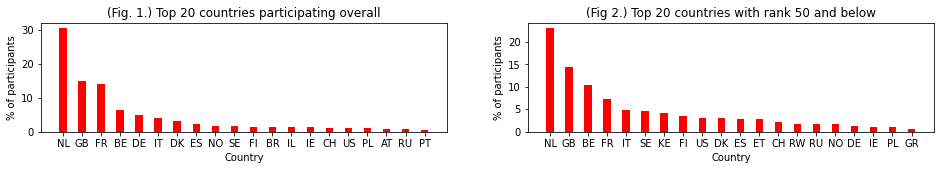

In [20]:
fig = plt.figure(figsize = (16,2))

series = df_clean.country.value_counts(normalize=True)[:20].mul(100)
top = df_clean[df_clean['rank'] <= 50].country.value_counts(normalize=True)[:20].mul(100)

plt.subplot(1, 2, 1)
plt.bar(list(series.index), list(series.values), color='red',width = 0.4)
plt.xlabel("Country")
plt.ylabel("% of participants")
plt.title("(Fig. 1.) Top 20 countries participating overall")

plt.subplot(1, 2, 2)
plt.bar(list(top.index), list(top.values), color='red',width = 0.4)
plt.xlabel("Country")
plt.ylabel("% of participants")
plt.title("(Fig 2.) Top 20 countries with rank 50 and below")

plt.show()

The graph below depicts the distribution of men's and women's finish times. The difference in distribution is visible on the left for the fastest finishing times, with male runners leading, but things begin to even out somewhere in the middle, as seen around the 16000 mark.

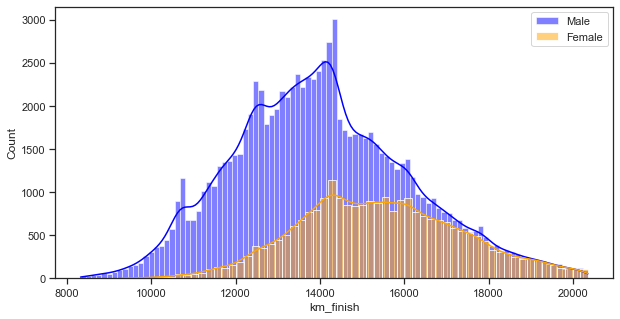

In [21]:
fig = plt.figure(figsize = (10,5))
sns.set(style="ticks")
sns.histplot(data=df_clean[df_clean['gender'] == 'M'], x="km_finish", color="blue", label="Male", kde=True)
sns.histplot(data=df_clean[df_clean['gender'] == 'F'], x="km_finish", color="orange", label="Female", kde=True)
plt.legend()
plt.show()

The categories, as previously stated, are mostly divided into age groups, with the exception of the senior runner categories (Msen and Vsen), which represent experienced runners, as evidenced by their placements, both of which are near the top. If we exclude the senior categories and only look at the age groups, we can see a pattern that suggests that if a participant is older, they are less likely to finish in the top 1000.

Text(0.5, 1.0, '(Fig. 2.) Percentage of female participants (rank < 1000)')

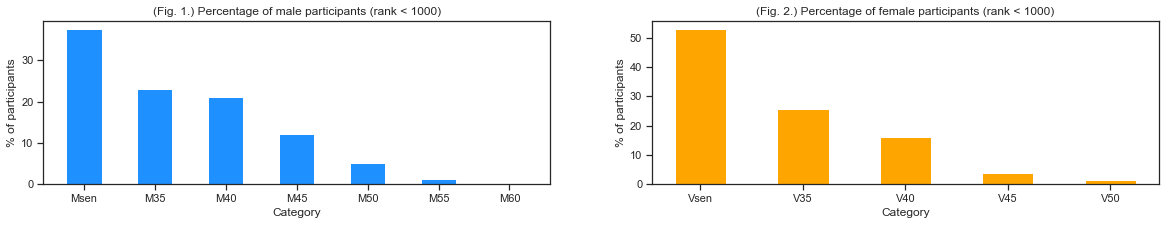

In [22]:
fig = plt.figure(figsize = (20,3))

male = df_clean[(df_clean['rank'] <= 500) & (df_clean.category.str.get(0) != 'V')].category.value_counts(normalize=True).mul(100)

female = df_clean[(df_clean['rank'] <= 500) & (df_clean.category.str.get(0) != 'M')].category.value_counts(normalize=True).mul(100)

plt.subplot(1, 2, 1)
plt.bar(list(male.index), list(male.values), color='dodgerblue',width = 0.5)
plt.xlabel("Category")
plt.ylabel("% of participants")
plt.title("(Fig. 1.) Percentage of male participants (rank < 1000)")

plt.subplot(1, 2, 2)
plt.bar(list(female.index), list(female.values), color='orange',width = 0.5)
plt.xlabel("Category")
plt.ylabel("% of participants")
plt.title("(Fig. 2.) Percentage of female participants (rank < 1000)")

### Split times
What exactly are split times? It is simply the time between the start of the race and the relevant checkpoint. For example, if a person's 5 kilometer split time is 14:30, it means it took them 14 minutes and 30 seconds to arrive at the checkpoint.

We can see in the graph below that split times and finish times have a strong correlation.

<AxesSubplot:>

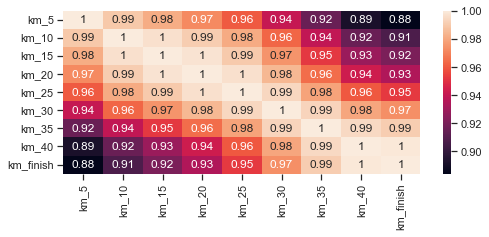

In [26]:
fig = plt.figure(figsize=(8,3))
sns.heatmap(df_clean[['km_5', 'km_10', 'km_15', 'km_20', 'km_25', 'km_30', 'km_35', 'km_40', 'km_finish']].corr(), annot=True)

The heatmap below demonstrates a link between the bib number and the final finish time. Therefore, if the bib number affects the finish time, it could mean that the numbers are not assigned at random but rather as a result of qualifying, with the lower qualifying time receiving the lower bib number, and vice versa.

<AxesSubplot:>

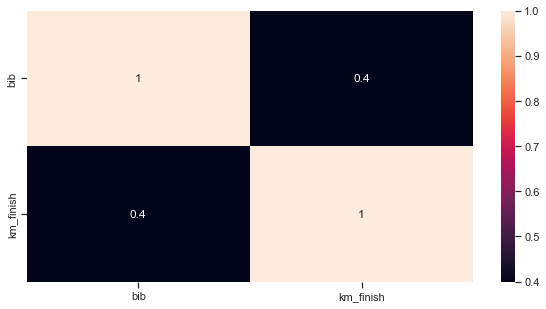

In [30]:
fig = plt.figure(figsize = (10,5))
sns.heatmap(df_clean[['bib', 'km_finish']].corr(), annot=True)

# Marathon time prediction
In the second part of our research question, we asked whether it was possible to predict marathon times and how accurate that would be. Our EDA revealed a number of relationships the variables gender, category, country, and even bib number had with the final finish time. Therefore, I believe it is possible to predict, but to what degree of accuracy is yet to be seen.

Because the finishing time is a continuous value, I will pick one of several regression methods to make the prediction. Linear Regression, Ridge Regression, Lasso Regression, Random Forest Regression, and K Nearest Neighbors Regression will be tested. To determine which one fits the best, the hyperparameters of each method (where applicable) will be tuned, and the methods will be compared to see which one produces the lowest error. The winning method will be used in the final prediction

### Feature engineering

Before we begin testing all of the methods, we want the features to be numerical.

- We will start by converting the gender column into two indicator variables gender_F and gender_M with the use of dummies.
- We can then either use a LabelEncoder to convert the category column to numbers, or we can use a replace map to better show the importance of each category. I chose the latter option even though either would have worked.
- Although the pycountry library can convert alpha-2 codes to their true numerical value, I chose to use a LabelEncoder because it works in the same way.

In [31]:
def change_to_numerical(dataframe):
    dft = dataframe.copy()
    
    replace_map = {'Msen':1,'M35':2,'M40':3,'M45':4,'M50':5,'Vsen':6,'M55':7,'V35':8,'V40':9,'M60':10,
                  'V45':11,'V50':12,'M65':13,'M70':14,'V60':15,'V55':16,'V65':17,'M75':18,'V70':19}
    
    dft['category'] = dft['category'].replace(replace_map)
    
    dft = pd.get_dummies(dft, columns=['gender'])
    
    l = LabelEncoder()
    dft['country'] = l.fit_transform(dft['country'])
    return dft

#### Transforming the database and splitting
I will use our new function to transform the database before splitting the train and test cases. The plan is to use 80% of the data for training and the remaining 20% for testing. Furthermore, because StandardScaler works well with regression, I will always apply it to the data before testing.

In [32]:
df_num = change_to_numerical(df_clean)
df_num.head()

,name,bib,country,rank,category_rank,category,date,km_5,km_10,km_15,km_20,km_21,km_25,km_30,km_35,km_40,km_finish,gender_F,gender_M
0,Ronald Schöer,29,107,25,25,1,2007,987,1938,2941,3927,4145,4919,5900,6892,7903,8372,0,1
1,César García,200,48,59,47,1,2007,1048,2051,3093,4122,4355,5195,6317,7470,8740,9349,0,1
4,Andrius Ramonas,214,88,57,46,1,2007,1089,2138,3247,4323,4563,5397,6493,7605,8774,9299,0,1
5,Raivis Zakis,194,66,44,37,1,2007,1084,2106,3189,4219,4447,5263,6285,7374,8530,9043,0,1
8,Eric Domérégo,205,52,53,43,1,2007,1082,2109,3190,4269,4512,5382,6500,7621,8745,9228,0,1


Although the split times will play a part in the final prediction, they will not be used to compare the regression methods.

In [33]:
X = df_num[['bib', 'category','country','gender_M', 'gender_F']]
y = df_num['km_finish']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling is done separately on the train and the test set.

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Picking the best method

To determine which method is best, their RMSE (Root Mean Squared Error) values will be compared. The sum of all squared differences between the actual and predicted values divided by the number of values is the mean squared error, and the square root of that value is the RMSE.

For this purpose, we will use **mean_squared_error()** with the squared=False parameter, which makes it an RMSE calculation.

We'll start with regular LinearRegression, which takes no hyperparameters, and measure its RMSE directly.

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

1943.7877199448633


We proceed to Lasso, which accepts a "alpha" parameter. We will try to tune this parameter and evaluate the model's performance.

In [36]:
lr = Lasso()
params = {'alpha':[0.01, 0.1, 0.10, 0.15, 0.20, 1, 10, 100, 150, 200, 250, 300]}
clf = GridSearchCV(lr, params, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': 0.01}


In [37]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

1943.7876624987562


Ridge Regression is a similar method; we will use the same parameter tuning to see what happens.

In [38]:
lr = Ridge()
params = {'alpha':[0.01, 0.1, 0.10, 0.15, 0.20, 1, 10, 100, 150, 200, 250, 300]}
clf = GridSearchCV(lr, params, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': 10}


In [39]:
lr = Ridge(alpha=10)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

1943.787819775858


While the difference between the three methods is negligible, Linear Regression performs the best. Next, we will investigate K Nearest Neighbors Regression and Random Forest Regression to see if there is room for improvement.

**KNeighborsRegressor** with the n neighbors parameter set to 40 shows a significant improvement. Can we accomplish more?

In [40]:
lr = KNeighborsRegressor()
params = {'n_neighbors':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]}
clf = GridSearchCV(lr, params, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'n_neighbors': 40}


In [41]:
lr = KNeighborsRegressor(n_neighbors=40)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

1849.8026454228439


We can see that RandomForestRegressor returns a smaller value than KNeighborsRegressor, therefore it is the best model out of the ones we chose, and so it will be used to make our final prediction.

In [42]:
lr = RandomForestRegressor(random_state = 40)
params = {'n_estimators':[100, 150, 200], 'max_depth':[2, 5, 10, 12]}
clf = GridSearchCV(lr, params, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'max_depth': 12, 'n_estimators': 200}


In [43]:
lr = RandomForestRegressor(n_estimators=200, max_depth=12)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

1826.810686314121


## The Final Prediction
Now that we have a fully featured dataset as well as a correct method, we can start making predictions. We'll use Mean Absolute Error this time to show the difference between actual and predicted values. We will also convert the final numbers to minutes to make things more readable.

We can see that predicting a participant's final time without them even starting the race has an error of 23 minutes while only using the base categories. What happens when we begin to introduce split times?

In [44]:
X = df_num[['bib', 'category','country','gender_M', 'gender_F']]
y = df_num['km_finish']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

23.779328222081826


,actual,predicted,error
11981,294.066667,223.058697,71.007970
82720,328.716667,282.099611,46.617056
40328,217.250000,244.254725,27.004725
78115,245.983333,240.507635,5.475699
90929,263.600000,223.244416,40.355584
...,...,...,...
5151,264.516667,238.471425,26.045241
26368,280.900000,241.470773,39.429227
32936,239.783333,222.981141,16.802193
118284,289.800000,240.855213,48.944787


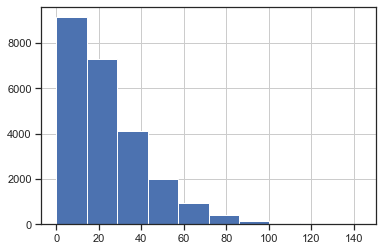

In [45]:
rf = RandomForestRegressor(n_estimators=200, max_depth=12)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

result = pd.DataFrame({"actual":y_test/60, "predicted":y_pred/60})
result['error'] = abs(result['predicted']-result['actual'])

print(np.mean(result['error']))
result['error'].hist()

result

# Split times
As previously stated, there is a strong relationship between split times and finish times. Naturally, incorporating them into our model(s) should improve accuracy. This means that as the runner progresses through the race, we can predict their final finish time with greater accuracy.

The final steps are as follows:
- Create 9 prediction models
- Each model gradually adds split features, starting from no features up to 40 km.
- Deploy the models and assess their accuracy to showcase the difference.
- Collect the models into a list and they're ready for use

**apply_prediction(X, y):**
- Splits into train and test cases, scales the data, applies machine learning model
- returns: dataframe that displays the error, model

In [46]:
def apply_prediction(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    rf = RandomForestRegressor(n_estimators=200, max_depth=12) # We are using our parameters
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    result = pd.DataFrame({"actual":y_test/60, "predicted":y_pred/60})
    result['error'] = abs(result['predicted']-result['actual'])
    print(np.mean(result['error']))
    result['error'].hist()
    return result, rf

#### Model 1 (no split times)

23.77272190534897


,actual,predicted,error
11981,294.066667,224.533299,69.533367
82720,328.716667,282.463319,46.253348
40328,217.250000,243.951400,26.701400
78115,245.983333,240.812540,5.170793
90929,263.600000,224.502598,39.097402
...,...,...,...
5151,264.516667,240.151430,24.365237
26368,280.900000,242.952580,37.947420
32936,239.783333,222.971923,16.811410
118284,289.800000,241.059540,48.740460


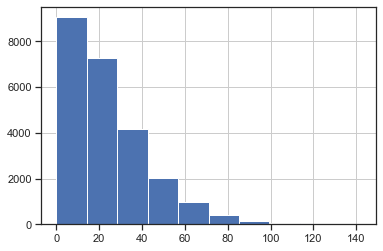

In [47]:
result, m1 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F']], df_num['km_finish'])
result

#### Model 2 (5KM)

12.101922833581813


,actual,predicted,error
11981,294.066667,251.288579,42.778087
82720,328.716667,292.951824,35.764843
40328,217.250000,231.056785,13.806785
78115,245.983333,273.443502,27.460169
90929,263.600000,276.517544,12.917544
...,...,...,...
5151,264.516667,242.093195,22.423472
26368,280.900000,290.425474,9.525474
32936,239.783333,250.714886,10.931552
118284,289.800000,278.173692,11.626308


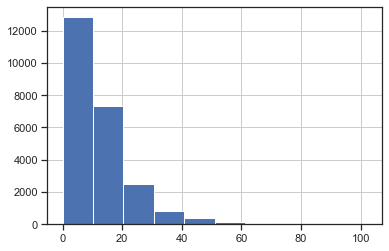

In [48]:
result, m2 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5']], df_num['km_finish'])
result

#### Model 3 (5KM, 10KM)

10.744889981519098


,actual,predicted,error
11981,294.066667,239.686135,54.380532
82720,328.716667,308.748282,19.968384
40328,217.250000,226.900956,9.650956
78115,245.983333,271.934380,25.951046
90929,263.600000,274.099983,10.499983
...,...,...,...
5151,264.516667,244.861139,19.655527
26368,280.900000,291.112919,10.212919
32936,239.783333,245.497830,5.714497
118284,289.800000,276.016134,13.783866


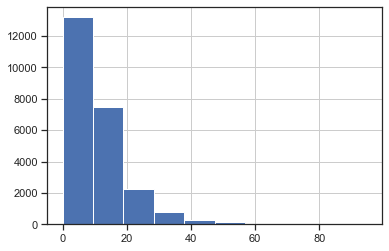

In [49]:
result, m3 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10']], df_num['km_finish'])
result

#### Model 4 (5KM, 10KM, 15KM)

9.493649058509972


,actual,predicted,error
11981,294.066667,261.497171,32.569495
82720,328.716667,318.745793,9.970874
40328,217.250000,222.755528,5.505528
78115,245.983333,267.629178,21.645845
90929,263.600000,270.633607,7.033607
...,...,...,...
5151,264.516667,250.477432,14.039235
26368,280.900000,291.506591,10.606591
32936,239.783333,249.805485,10.022152
118284,289.800000,270.552141,19.247859


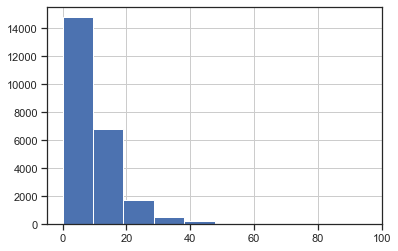

In [50]:
result, m4 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15']], df_num['km_finish'])
result

#### Model 5 (5KM, 10KM, 15KM, 20KM)

7.881058148846326


,actual,predicted,error
11981,294.066667,290.326908,3.739759
82720,328.716667,324.985581,3.731086
40328,217.250000,221.931203,4.681203
78115,245.983333,256.980030,10.996696
90929,263.600000,268.488487,4.888487
...,...,...,...
5151,264.516667,260.585408,3.931259
26368,280.900000,282.541789,1.641789
32936,239.783333,249.504500,9.721166
118284,289.800000,281.450679,8.349321


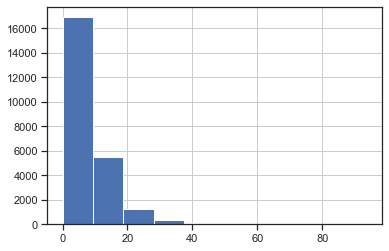

In [51]:
result, m5 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15','km_20']], df_num['km_finish'])
result

#### Model 6 (5KM, 10KM, 15KM, 20KM, 25KM)

6.094657712303312


,actual,predicted,error
11981,294.066667,298.114854,4.048188
82720,328.716667,327.730094,0.986573
40328,217.250000,220.254166,3.004166
78115,245.983333,243.570599,2.412734
90929,263.600000,269.346320,5.746320
...,...,...,...
5151,264.516667,266.494811,1.978144
26368,280.900000,277.209190,3.690810
32936,239.783333,244.242691,4.459358
118284,289.800000,289.840525,0.040525


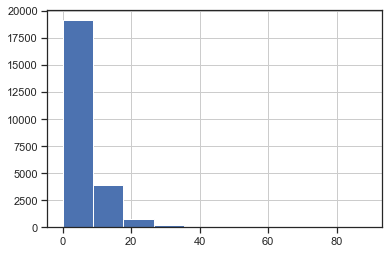

In [52]:
result, m6 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15','km_20','km_25']], df_num['km_finish'])
result

#### Model 7 (5KM, 10KM, 15KM, 20KM, 25KM, 30KM)

4.023496357561617


,actual,predicted,error
11981,294.066667,294.353916,0.287250
82720,328.716667,328.045874,0.670793
40328,217.250000,218.175718,0.925718
78115,245.983333,242.895609,3.087725
90929,263.600000,266.528189,2.928189
...,...,...,...
5151,264.516667,267.667526,3.150859
26368,280.900000,269.044246,11.855754
32936,239.783333,243.284237,3.500903
118284,289.800000,287.490231,2.309769


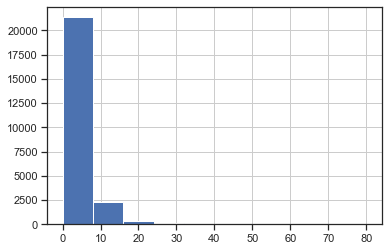

In [53]:
result, m7 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15','km_20','km_25', 'km_30']], df_num['km_finish'])
result

#### Model 8 (5KM, 10KM, 15KM, 20KM, 25KM, 30KM, 35KM)

2.2381595267110894


,actual,predicted,error
11981,294.066667,293.644668,0.421999
82720,328.716667,328.389963,0.326704
40328,217.250000,218.225567,0.975567
78115,245.983333,244.136125,1.847208
90929,263.600000,264.847451,1.247451
...,...,...,...
5151,264.516667,263.783503,0.733164
26368,280.900000,270.672288,10.227712
32936,239.783333,240.597409,0.814076
118284,289.800000,289.124339,0.675661


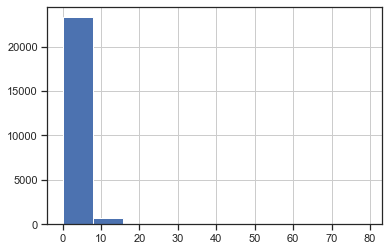

In [54]:
result, m8 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15','km_20','km_25', 'km_30', 'km_35']], df_num['km_finish'])
result

#### Model 9 (5KM, 10KM, 15KM, 20KM, 25KM, 30KM, 35KM, 40KM)

0.6647988100441938


,actual,predicted,error
11981,294.066667,294.182995,0.116328
82720,328.716667,328.632810,0.083857
40328,217.250000,217.259216,0.009216
78115,245.983333,245.578389,0.404945
90929,263.600000,263.518746,0.081254
...,...,...,...
5151,264.516667,265.416009,0.899343
26368,280.900000,280.816720,0.083280
32936,239.783333,240.230561,0.447228
118284,289.800000,290.843723,1.043723


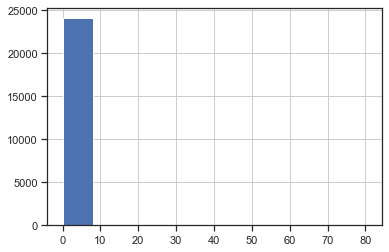

In [55]:
result, m9 = apply_prediction(df_num[['bib', 'category','country','gender_M', 'gender_F', 
                         'km_5','km_10','km_15','km_20','km_25', 'km_30', 'km_35', 'km_40']], df_num['km_finish'])
result

We have all 9 models and they are ready to be used.

In [56]:
full_models = [m1,m2,m3,m4,m5,m6,m7,m8,m9]

# Summary

In conclusion, we learned that bib number, age group, country, and gender can all influence a runner's final running time. We also discovered that it is possible to predict a runner's final time even before they begin the race, but the accuracy improves greatly as they continue to pass the marathon checkpoints.

This kind of prediction could be useful marketing. In a large marathon like this, the camera tends to focus on the race's leaders, and if a person is predicted to do well, it would be wise for marketing companies to promote their products through him because he will get more exposure.